In [135]:
# === Configuration ===
ckpt_dir = "/home/joseph_tennyson/182/in-context-learning-GLM/src/models/poisson-0.32"
only_last = False
n_tasks = 10000
n_train = 40
lr = 0.05
max_steps = 10000
tol = 1e-10


In [136]:
# === Imports ===
import os
import yaml
import torch
from types import SimpleNamespace
from tqdm import tqdm
from torch.nn import PoissonNLLLoss
from models import build_model  # Ensure this is in your working directory

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [137]:
# === Data Sampling ===
def sample_data(n_tasks, n_points, d, scale=0.32):
    xs = torch.randn(n_tasks, n_points, d)
    ws = scale * torch.randn(n_tasks, d, 1)
    logits = xs @ ws
    ys = torch.poisson(torch.exp(logits.clamp(max=4))).squeeze(-1)
    return xs, ys, ws


In [138]:
# === Load Config===
config_path = os.path.join(ckpt_dir, "config.yaml")
cfg = yaml.load(open(config_path), Loader=yaml.FullLoader)

model_conf = SimpleNamespace(**cfg["model"])

# === Sample Data ===
d = cfg["model"]["n_dims"]
scale = cfg["training"]["task_kwargs"].get("scaling", 1.0)
xs_all, ys_all, _ = sample_data(n_tasks, n_train + 1, d, scale)
xs_train, xs_test = xs_all[:, :-1].to(device), xs_all[:, -1:].to(device)
ys_train, ys_test = ys_all[:, :-1].to(device), ys_all[:, -1:].to(device)


In [139]:
# === Transformer Evaluation ===
def evaluate_transformer(model, ckpt_file, xs_all, ys_all, xs_test, ys_test):
    # model.eval()

    # with torch.no_grad():
    #     out = model(xs_all, ys_all)
    #     last_loglam = out[:, -1]
    #     loss_fn = PoissonNLLLoss(log_input=True, full=True, reduction="mean")
    #     loss = loss_fn(last_loglam.unsqueeze(-1), ys_test)
    # print(f"{os.path.basename(ckpt_file)} | Transformer Poisson NLL: {loss.item():.4f}")
    
    model.eval()
    with torch.no_grad():
        out = model(xs_all, ys_all)  # shape: [n_tasks, seq_len]
        loss_fn = PoissonNLLLoss(log_input=True, full=True, reduction="none")
        loss = loss_fn(out, ys_all).mean(dim=0)
        
        return loss
    print(f"{os.path.basename(ckpt_file)} | Transformer Poisson NLL (all points): {loss.item():.4f}")


In [140]:
# === Oracle Gradient Descent Evaluation ===
import torch
from torch.nn import PoissonNLLLoss
from tqdm import tqdm

def evaluate_oracle(xs_all, ys_all, lr, max_steps, tol, scale=0.32):
    n_tasks, n_points, d = xs_all.shape
    loss_fn = PoissonNLLLoss(log_input=True, full=True, reduction="mean")
    loss_fn_no_reduce = PoissonNLLLoss(log_input=True, full=True, reduction="none")
    all_losses = []

    for t in tqdm(range(1, n_points), desc="Context Size"):

        xs_train = xs_all[:, :t, :]
        ys_train = ys_all[:, :t]
        xs_test = xs_all[:, t:t+1, :]
        ys_test = ys_all[:, t:t+1]

        w_hat = torch.randn(n_tasks, d, 1, device=xs_all.device, requires_grad=True)
        opt = torch.optim.Adam([w_hat], lr=lr)

        prev = float("inf")
        converged = False

        for step in range(1, max_steps + 1):
            logits = (xs_train @ w_hat).squeeze(-1).clamp(max=4)
            # pred = torch.exp(logits)
            pred = logits
            loss = loss_fn(pred, ys_train)
            
            l2_penalty = (0.5 / scale**2) * w_hat.pow(2).sum() / (n_tasks * t) 
            loss += l2_penalty
    
            if abs(prev - loss.item()) < tol:
                converged = True
                break
            prev = loss.item()
            opt.zero_grad()
            loss.backward()
            opt.step()

        if not converged:
            tqdm.write(f"[Context {t}] DID NOT converge (final Δloss={abs(prev - loss.item()):.2e})")

        with torch.no_grad():
            logits_test = (xs_test @ w_hat).squeeze(-1).clamp(max=4)
            # pred_test = torch.exp(logits_test)
            pred_test = logits_test
            loss = loss_fn_no_reduce(pred_test, ys_test)
            avg_loss = loss.mean().item()
            all_losses.append(avg_loss)

    return all_losses




In [152]:
import torch
from torch.nn import PoissonNLLLoss
from tqdm import tqdm
import random

def sample_data(n_tasks, n_points, d, scale=0.32):
    xs = torch.randn(n_tasks, n_points, d)
    ws = scale * torch.randn(n_tasks, d, 1)
    logits = xs @ ws
    ys = torch.poisson(torch.exp(logits.clamp(max=4))).squeeze(-1)
    return xs, ys, ws

def run_oracle_on_random_context(context_len, n_tasks, d, lr, max_steps, tol, device="cuda", scale=0.32):
    xs_all, ys_all, _ = sample_data(n_tasks, context_len, d)

    # Evaluate only at max context size (i.e., context_len - 1)
    t = context_len - 1
    xs_train = xs_all[:, :t, :].to(device)
    ys_train = ys_all[:, :t].to(device)
    xs_test = xs_all[:, t:t+1, :].to(device)
    ys_test = ys_all[:, t:t+1].to(device)

    loss_fn = PoissonNLLLoss(log_input=True, full=True, reduction="mean")
    loss_fn_no_reduce = PoissonNLLLoss(log_input=True, full=True, reduction="none")

    w_hat = torch.randn(n_tasks, d, 1, device=device, requires_grad=True)
    opt = torch.optim.Adam([w_hat], lr=lr)

    prev = float("inf")
    for step in range(1, max_steps + 1):
        logits = (xs_train @ w_hat).squeeze(-1).clamp(max=4)
        pred = logits
        loss = loss_fn(pred, ys_train)
        
        l2_penalty = (0.5 / scale**2) * w_hat.pow(2).sum() / (n_tasks * t) 
        loss += l2_penalty
    
        
        if abs(prev - loss.item()) < tol:
            print(f"[Context {t}] Converged at step {step}")
            break
        prev = loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
    else:
        print(f"[Context {t}] DID NOT converge (final Δloss={abs(prev - loss.item()):.2e})")

    with torch.no_grad():
        logits_test = (xs_test @ w_hat).squeeze(-1).clamp(max=4)
        pred_test = logits_test
        loss = loss_fn_no_reduce(pred_test, ys_test)
        avg_loss = loss.mean().item()

    print(f"[Context {t}] Test Loss: {avg_loss:.4f}")
    return avg_loss


device = "cuda" if torch.cuda.is_available() else "cpu"
# o1 = run_oracle_on_random_context(context_len=2000, n_tasks=2000, d=10, lr=0.05, max_steps=10000, tol=1e-10, device=device)
# o2 = run_oracle_on_random_context(context_len=3000, n_tasks=2000, d=10, lr=0.05, max_steps=10000, tol=1e-10, device=device)
# o3 = run_oracle_on_random_context(context_len=5000, n_tasks=2000, d=10, lr=0.05, max_steps=10000, tol=1e-10, device=device)

# long_context_oracle = min(o1, o2, o3)
run_oracle_on_random_context(context_len=20, n_tasks=10000, d=10, lr=0.05, max_steps=10000, tol=1e-10, device=device)

[Context 19] Converged at step 254
[Context 19] Test Loss: 1.7321


1.7321101427078247

In [142]:
# === Naive Baseline Evaluation ===
import torch
from torch.nn import PoissonNLLLoss

def evaluate_naive(ys_all):
    _, n_points = ys_all.shape
    loss_fn = PoissonNLLLoss(log_input=False, full=True, reduction="none")
    losses = []

    for t in range(1, n_points):  
        ys_train = ys_all[:, :t]         
        ys_test = ys_all[:, t:t+1]       

        naive_mean = ys_train.mean(dim=1, keepdim=True)  
        pred = naive_mean  

        loss = loss_fn(pred, ys_test).mean().item()  
        losses.append(loss)

    return losses



In [143]:
pt_files = sorted(f for f in os.listdir(ckpt_dir) if f.endswith(".pt"))
models = []

for fname in pt_files:
    ckpt_path = os.path.join(ckpt_dir, fname)
    state = torch.load(ckpt_path, map_location=device)
    
    model = build_model(model_conf).to(device)
    
    print(f"Loading checkpoint {fname}...")
    model.load_state_dict(state['model_state_dict'] if 'model_state_dict' in state else state)
    
    models.append([model, fname])

Loading checkpoint model_1000.pt...
Loading checkpoint model_2000.pt...
Loading checkpoint model_3000.pt...
Loading checkpoint model_4000.pt...
Loading checkpoint model_5000.pt...
Loading checkpoint model_6000.pt...
Loading checkpoint model_7000.pt...
Loading checkpoint state.pt...


In [144]:
losses = []

# === Run Transformer Models ===
pt_files = sorted(f for f in os.listdir(ckpt_dir) if f.endswith(".pt"))

for model, fname in models:
    if only_last and fname != 'state.pt':
        continue
    print(f"Evaluating checkpoint {fname}...")
    losses.append([fname, evaluate_transformer(model, fname, xs_train, ys_train, xs_test, ys_test)])


Evaluating checkpoint model_1000.pt...
Evaluating checkpoint model_2000.pt...
Evaluating checkpoint model_3000.pt...
Evaluating checkpoint model_4000.pt...
Evaluating checkpoint model_5000.pt...
Evaluating checkpoint model_6000.pt...
Evaluating checkpoint model_7000.pt...
Evaluating checkpoint state.pt...


In [145]:
# === Run Oracle & Naive ===
oracle_losses = evaluate_oracle(xs_all, ys_all, lr, max_steps, tol)
naive_losses = evaluate_naive(ys_all)

Context Size: 100%|██████████| 40/40 [00:15<00:00,  2.64it/s]


In [146]:
oracle_losses[:20]

[2.4336390495300293,
 2.2755143642425537,
 2.2746317386627197,
 2.185077428817749,
 2.2419674396514893,
 2.100375175476074,
 2.191695213317871,
 1.9870892763137817,
 2.0466768741607666,
 1.9460678100585938,
 1.9618176221847534,
 1.9382017850875854,
 1.875357985496521,
 1.8629765510559082,
 1.841090202331543,
 1.7969567775726318,
 1.7759308815002441,
 1.7876861095428467,
 1.752903699874878,
 1.7106741666793823]

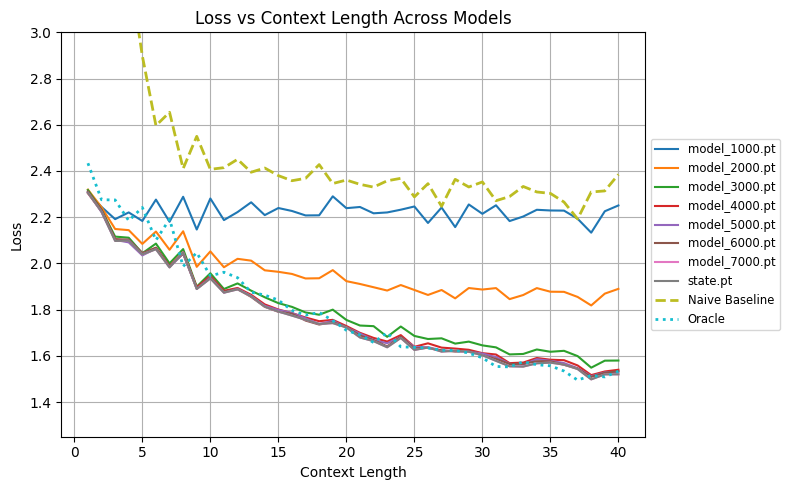

In [147]:
import matplotlib.pyplot as plt
top = 3
bottom = 1.25

plt.figure(figsize=(8, 5))
plt.ylim(top=top, bottom=bottom)

# Plot the original model losses
for name, values in losses:
    x = list(range(1, len(values) + 1))  # Shifted context length
    plt.plot(x, values, label=name)

# Add naive and oracle baselines
x = list(range(1, len(naive_losses) + 1))  # context lengths = 1 to n-1
plt.plot(x, naive_losses, label="Naive Baseline", linestyle="--", linewidth=2)
plt.plot(x, oracle_losses, label="Oracle", linestyle=":", linewidth=2)


# Final formatting
plt.xlabel("Context Length")
plt.ylabel("Loss")
plt.title("Loss vs Context Length Across Models")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="small")
plt.grid(True)
plt.tight_layout()
plt.show()
